In [1]:
%pylab inline
from scipy import ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

import sys
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.gridspec as gridspec
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.scalebar import IMPERIAL_LENGTH
sys.path.append('../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from tractionforce.norms import *
from tractionforce.problem import *
from joblib import Parallel, delayed
import multiprocessing
import pickle
import gzip

from PIL import Image


def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
    
def extractn(inlist,n):
    try:
        return inlist[n]
    except:
        return None

Populating the interactive namespace from numpy and matplotlib


In [2]:
padresults_1 = pickle.load(gzip.open('results/pads_2.gz', 'rb'))
padresults_2 = pickle.load(gzip.open('results/pads_2_L2.gz', 'rb'))
padresults_3 = pickle.load(gzip.open('results/pads_2iso.gz', 'rb'))
padresults_4 = pickle.load(gzip.open('results/pads_2_tv1.gz', 'rb'))
padresults_5 = pickle.load(gzip.open('results/pads_2_tv2.gz', 'rb'))



pad_results = [ padresults_1,padresults_2,padresults_3,padresults_4,padresults_5]


pad_im = Image.open('pads/padmask.tif')
pad_imarray = np.flip(np.array(pad_im),0)

pad_mask = pad_imarray == 0
pad_distance = -ndimage.distance_transform_edt(pad_mask) + ndimage.distance_transform_edt(1 - pad_mask)
pad_distance = pad_distance.flatten()

N = 160
M = 120

Phi_labels = [r"$\tilde{\Phi}_{L^1}$",
             r"$\tilde{\Phi}_{L^2}$",
             r"$\Phi_{L^1}$",
             r"$\Phi_{TV_1}$",
             r"$\Phi_{TV_2}$"]

In [3]:
x_forward_positions = np.arange(N)
y_forward_positions = np.arange(M)

dx = abs(x_forward_positions[1]-x_forward_positions[0])
dy = abs(y_forward_positions[1]-y_forward_positions[0])

forward_coords = [[ [x,y] for x in x_forward_positions] for y in y_forward_positions] 
forward_coords = np.array([item for sublist in forward_coords for item in sublist])

scaling = 25


r1 = 1.0/5*scaling
r2 = 1.0/6*scaling
r3 = 1.0/8*scaling
r4 = 1.0/4*scaling

c1 = np.array((-1,-1/2.))
c2 = np.array((0,-1))
c3 = np.array((2,1))
c4 = np.array((0,1))



d1 = ((forward_coords[:,0]-N/2.-c1[0]*scaling)**2 + (forward_coords[:,1]-M/2-c1[1]*scaling)**2)**0.5 # already up-scaled
d2 = ((forward_coords[:,0]-N/2.-c2[0]*scaling)**2 + (forward_coords[:,1]-M/2-c2[1]*scaling)**2)**0.5
d3 = ((forward_coords[:,0]-N/2.-c3[0]*scaling)**2 + (forward_coords[:,1]-M/2-c3[1]*scaling)**2)**0.5
d4 = ((forward_coords[:,0]-N/2.-c4[0]*scaling)**2 + (forward_coords[:,1]-M/2-c4[1]*scaling)**2)**0.5

A1 = np.pi * r1**2
A2 = np.pi * r2**2
A3 = np.pi * r3**2
A4 = np.pi * r4**2

a12 = 1e-4
a23 = 2e-4
g4 = 9e-5

G4 = g4*pi*(r4)**2/3.

s1_x = a12
s1_y = -a12/2.

s2_x = -a12*A1/A2 + a23
s2_y = G4/A2+a12*A1/A2/2. + a23

s3_x = -G4/A3 - a23*A2/A3
s3_y = -a23*A2/A3


in_1 = d1<=r1 
in_2 = d2<=r2 
in_3 = d3<=r3 
in_4 = d4<=r4 

stress_x = np.zeros(forward_coords.shape[0])
stress_y = np.zeros(forward_coords.shape[0])

stress_x[in_1] = s1_x * A1/sum(in_1)
stress_y[in_1] = s1_y * A1/sum(in_1)


stress_x[in_2] = s2_x * A2/sum(in_2)
stress_y[in_2] = s2_y * A2/sum(in_2)

stress_x[in_3] = s3_x * A3/sum(in_3)
stress_y[in_3] = s3_y * A3/sum(in_3)

stress_x[in_4] = g4*(1-d4[in_4]/r4)
stress_y[in_4] = -g4*(1-d4[in_4]/r4)

stress_x[in_4] *= G4/sum(stress_x[in_4])
stress_y[in_4] *= -G4/sum(stress_y[in_4])

# add the cone for region 4

pad_x = stress_x.reshape((M,N))
pad_y = stress_y.reshape((M,N))

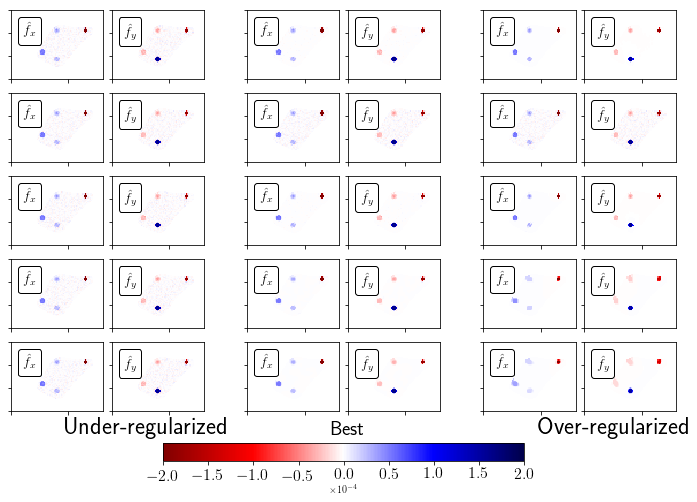

In [7]:
fig = plt.figure(figsize=(12,10))
ax = []
im = []

maxmagnitude = 2
gs0 = gridspec.GridSpec(len(pad_results)+1,1)

gs_j = []

gs_j_innergrids = []


#################### Truth
gs_j += [gridspec.GridSpecFromSubplotSpec(1,3,
                subplot_spec=gs0[0],hspace = 0.1,
                width_ratios = [ 1,1,1])]
#######################



# plot out the truth

for j in range(5):
    gs_j += [gridspec.GridSpecFromSubplotSpec(1,3,
                subplot_spec=gs0[j+1],hspace = 0.1,
                width_ratios = [ 1,1,1])]
                #height_ratios = [1,1,1,1,1,1,1])]
    gs_j_innergrids+= [[]]
    
    #ax += [plt.Subplot(fig, gs_j[j][0,0])]
    #fig.add_subplot(ax[-1])
    
    data_error = [extractn(res,2) for res in pad_results[j]][:-1]
    reg_error = [extractn(res,3) for res in pad_results[j]][:-1]
    lvals = [extractn(res,4) for res in pad_results[j]][:-1]

    l_curve_distances = np.abs((reg_error[-1]-reg_error[0])*np.array(data_error) -  \
                (data_error[-1]-data_error[0])*np.array(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])
    best = np.argsort(l_curve_distances)[-1]

    #plt.xlim((0.04,0.18))
    #plt.xticks(np.arange(0.04,0.18,0.02))
    #ax[-1].plot( np.array(data_error)*1e7, reg_error)
    #ax[-1].scatter(data_error[best],reg_error[best],s=100, facecolors='none', edgecolors='r')
    #ax[-1].scatter(data_error[0],reg_error[0],s=100, facecolors='none', edgecolors='g')
    #ax[-1].scatter(data_error[-1],reg_error[-1],s=100, facecolors='none', edgecolors='black')

    #plt.xlabel("$\Phi$", fontsize=16)
    #ax[-1].set_ylabel(Phi_labels[j], fontsize=20)
    #plt.title('', fontsize=16)
    #plt.text(data_error[best]*1.05,reg_error[best]*1.1,, horizontalalignment='left')
    #ax[-1].annotate("$\quad\lambda=" + latex_float(lvals[best]) +"$", (data_error[best],reg_error[best]))
    
    
    ###########################################################################
    # Under regularized ######
    ###########################################################################
    gs_j_innergrids[j] += [gridspec.GridSpecFromSubplotSpec(1,2,
            subplot_spec = gs_j[j][0,0], wspace=0.05, hspace = 0.05)]    

    
    bestresult = pad_results[j][0]
    best_s_vals_x = bestresult[0][0]*1e4
    best_s_vals_y = bestresult[0][1]*1e4
    
    ax += [plt.Subplot(fig, gs_j_innergrids[j][-1][0,0])]
    fig.add_subplot(ax[-1])
    
    ## axis
    
    at = AnchoredText("$\hat{f}_{x}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)

    z = np.ma.masked_array(best_s_vals_x, np.abs(best_s_vals_x) < 1e-6)    
    im += [ax[-1].pcolormesh(z,
                        cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude)]
    im[-1].axes.set_aspect('equal')
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])    
    ax += [plt.Subplot(fig, gs_j_innergrids[j][-1][0,1])]
    fig.add_subplot(ax[-1])
        
    at = AnchoredText("$\hat{f}_{y}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
    
    z = np.ma.masked_array(best_s_vals_y, np.abs(best_s_vals_y) < 1e-5)        
    ax[-1].pcolormesh(z,
                        cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])    
    ##############################################################
    ############Plot the best
    ##############################################################
    
    gs_j_innergrids[j] += [gridspec.GridSpecFromSubplotSpec(1,2,
            subplot_spec = gs_j[j][0,1], wspace=0.05, hspace = 0.05)]    

    
    bestresult = pad_results[j][best]
    best_s_vals_x = bestresult[0][0]*1e4
    best_s_vals_y = bestresult[0][1]*1e4
    
    ax += [plt.Subplot(fig, gs_j_innergrids[j][-1][0,0])]
    fig.add_subplot(ax[-1])
    
    ## axis
    
    at = AnchoredText("$\hat{f}_{x}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)

    z = np.ma.masked_array(best_s_vals_x, np.abs(best_s_vals_x) < 1e-6)    
    ax[-1].pcolormesh(z,
                        cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])    
    ax += [plt.Subplot(fig, gs_j_innergrids[j][-1][0,1])]
    fig.add_subplot(ax[-1])
    
    
    at = AnchoredText("$\hat{f}_{y}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
    
    z = np.ma.masked_array(best_s_vals_y, np.abs(best_s_vals_y) < 1e-5)        
    ax[-1].pcolormesh(z,
                        cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])    
    ##################################3#############
    ############plot the over-regularized
    #######################################################
    
    gs_j_innergrids[j] += [gridspec.GridSpecFromSubplotSpec(1,2,
            subplot_spec = gs_j[j][0,2], wspace=0.05, hspace = 0.05)]    

    
    bestresult = pad_results[j][-1]
    best_s_vals_x = bestresult[0][0]*1e4
    best_s_vals_y = bestresult[0][1]*1e4
    
    ax += [plt.Subplot(fig, gs_j_innergrids[j][-1][0,0])]
    fig.add_subplot(ax[-1])
    
    ## axis
    
    at = AnchoredText("$\hat{f}_{x}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)

    z = np.ma.masked_array(best_s_vals_x, np.abs(best_s_vals_x) < 1e-6)    
    ax[-1].pcolormesh(z,
                        cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')
    
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    
    ax += [plt.Subplot(fig, gs_j_innergrids[j][-1][0,1])]
    fig.add_subplot(ax[-1])
    
    
    at = AnchoredText("$\hat{f}_{y}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
    
    z = np.ma.masked_array(best_s_vals_y, np.abs(best_s_vals_y) < 1e-5)        
    ax[-1].pcolormesh(z,
                        cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    
#ax[-7].set_xlabel(r"$\Phi_{\textrm{data}}$",fontsize=24)
#ax[0].set_title(r"$\Phi_{\textrm{data}}$",fontsize=24)

cb = fig.colorbar(im[0], ax = ax, fraction=0.04, pad=0.07,  orientation='horizontal' ) #format=ticker.FuncFormatter(fmt),
cb.ax.tick_params(labelsize=16)
cb.set_label(label=r"$\times 10^{-4}$")
#plt.savefig("fig2.pdf",bbox_inches='tight', 
#               transparent=True,
#               pad_inches=0, dpi=400)

ax[-5].text(-40,-20,r"Under-regularized",fontsize=24)
ax[-3].text(-15,-20,r"Best",fontsize=20)
ax[-1].text(-40,-20,r"Over-regularized",fontsize=24)

#plt.savefig("../figures/fig3.pdf",bbox_inches='tight', 
#               transparent=True)   

NameError: name 'gs_j_right' is not defined

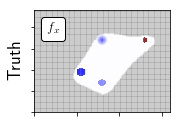

In [9]:
fig = plt.figure(figsize=(5,14))
ax = []
im = []

maxmagnitude = 2
gs0 = gridspec.GridSpec(len(pad_results)+1,1)

j = 0

gs_j = []
gs_j += [gridspec.GridSpecFromSubplotSpec(1,1,
                subplot_spec=gs0[0],hspace = 0.02 )]

gs_j_innergrids = []

gs_j_innergrids+= [[]]
#################### Truth
gs_j_innergrids[j] += [gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec = gs_j[j][0,0], wspace=0.05, hspace = 0.05)]  
#######################


ax += [plt.Subplot(fig, gs_j_innergrids[j][-1][0,0])]
fig.add_subplot(ax[-1])
im+= [ax[-1].pcolormesh(pad_x* 1e4,rasterized=True,
                     cmap='seismic_r',vmax=maxmagnitude,vmin=-maxmagnitude)]
im[-1].axes.set_aspect('equal')
ax[-1].pcolormesh(pad_imarray==0,rasterized=True,
                           cmap='gray',alpha=0.05).axes.set_aspect('equal')
ax[-1].set_yticklabels([])
ax[-1].set_xticklabels([])
ax[-1].set_ylabel("Truth",fontsize=18)

at = AnchoredText("${f}_{x}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

ax += [plt.Subplot(fig, gs_j_right[0][0,1])]
fig.add_subplot(ax[-1])
ax[-1].pcolormesh(pad_y* 1e4,rasterized=True,
                     cmap='seismic_r',vmax=maxmagnitude,vmin=-maxmagnitude).axes.set_aspect('equal')
ax[-1].pcolormesh(pad_imarray==0,rasterized=True,
                           cmap='gray',alpha=0.05).axes.set_aspect('equal')
ax[-1].set_yticklabels([])
ax[-1].set_xticklabels([])

at = AnchoredText("${f}_{y}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

#########################


for j in range(5):
    gs_j += [gridspec.GridSpecFromSubplotSpec(1,1,
                subplot_spec=gs0[j+1],hspace = 0.02 )]

    gs_j_innergrids+= [[]]
    
    #ax += [plt.Subplot(fig, gs_j[j][0,0])]
    #fig.add_subplot(ax[-1])
    
    data_error = [extractn(res,2) for res in pad_results[j]][:-1]
    reg_error = [extractn(res,3) for res in pad_results[j]][:-1]
    lvals = [extractn(res,4) for res in pad_results[j]][:-1]

    l_curve_distances = np.abs((reg_error[-1]-reg_error[0])*np.array(data_error) -  \
                (data_error[-1]-data_error[0])*np.array(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])
    best = np.argsort(l_curve_distances)[-1]

   
    ##############################################################
    ############Plot the best
    ##############################################################
    
    gs_j_innergrids[j] += [gridspec.GridSpecFromSubplotSpec(1,2,
            subplot_spec = gs_j[j][0,0], wspace=0.05, hspace = 0.05)]    

    
    bestresult = pad_results[j][best]
    best_s_vals_x = bestresult[0][0]*1e4
    best_s_vals_y = bestresult[0][1]*1e4
    
    ax += [plt.Subplot(fig, gs_j_innergrids[j][-1][0,0])]
    fig.add_subplot(ax[-1])
    
    ## axis
    
    at = AnchoredText("$\hat{f}_{x}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)

    z = np.ma.masked_array(best_s_vals_x, np.abs(best_s_vals_x) < 1e-6)    
    im += [ax[-1].pcolormesh(z, rasterized = True,
                        cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude)]
    im[-1].axes.set_aspect('equal')
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])    
    ax[-1].set_ylabel(Phi_labels[j], fontsize=20)
    ax += [plt.Subplot(fig, gs_j_innergrids[j][-1][0,1])]
    fig.add_subplot(ax[-1])
    
    
    at = AnchoredText("$\hat{f}_{y}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
    
    z = np.ma.masked_array(best_s_vals_y, np.abs(best_s_vals_y) < 1e-6)        
    ax[-1].pcolormesh(z, rasterized = True,
                        cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])    
    

cb = fig.colorbar(im[0], ax = ax, fraction=0.04, pad=0.02,  orientation='horizontal' ) #format=ticker.FuncFormatter(fmt),
cb.ax.tick_params(labelsize=16)
cb.set_label(label=r"$\times 10^{-4}$")
#plt.savefig("fig2.pdf",bbox_inches='tight', 
#               transparent=True,
#               pad_inches=0, dpi=400)



#plt.savefig("../figures/fig3.pdf",bbox_inches='tight', 
#               transparent=True)   